<a href="https://colab.research.google.com/github/urielzil/Deep_Learning_Emails_Project/blob/main/Deep_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Project: Email spam detection***

by Uriel Zilberberg, Eilon Toledano, Barry Yosilevich



# ***Introduction***
Our task would be, building an email spam detector - given the email context, the model will decide whether an email is spam or not.

Some of the benefits that an email spam detector can provide:

* Improved Email Productivity: By detecting and filtering spam emails, a spam detector helps to reduce the amount of time users spend sorting through their inboxes, allowing them to focus on important emails.

* Increased Email Security: Spam emails often contain malicious links or attachments that can compromise a user's security. A spam detector helps to prevent these emails from reaching users' inboxes, improving overall email security.

* Reduced Server Load: By filtering out a large volume of spam emails, a spam detector helps to reduce the load on email servers, improving their overall performance and reliability.

* Better User Experience: A spam detector enhances the overall email experience for users by reducing the amount of unwanted and irrelevant emails they receive, making their email inboxes more organized and manageable.

* Data Protection: Spam emails often contain phishing attempts or other forms of identity theft, which can compromise a user's personal and sensitive information. A spam detector helps to prevent these emails from reaching users, protecting their data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
import torch.optim as optim

# ***Dataset***
We obtainted the data from Kaggle website.

The data contains the content of 6216 emails, with a spam percentage of about **29%**


In [ ]:
# preprocess - emails to table 
raw_file_path = '/content/drive/MyDrive/Intro_to_Deep_Learning/spam_or_ham_dataset.csv' 
final_file_path = '/content/drive/MyDrive/Intro_to_Deep_Learning/emails.csv' 
raw_data = pd.read_csv(raw_file_path)

example_text = raw_data["text"][0]
print(example_text)

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [ ]:
raw_data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
6211,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
6212,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
6213,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
6214,1409,ham,Subject: industrial worksheets for august 2000...,0


In [ ]:
# Spam Percentage compute:
print("Spam percentage: {}".format(raw_data["label_num"].mean()))

Spam percentage: 0.28603603603603606



# ***Preprocessing***

Included:

* Splitting emails' content, filtering spaces, non-digits and non-letters.

* Lower case all letters.

* Replacing all digits within email's body with 0, so only number's length will be considered.

* Creating a vocabulary of all words conatained in the emails dataset, which eventually contains more than 45,000 different words. 

* Remove all words that appear less than 10 times in all emails.

* Turn each email to a vector of vocabulary's length, where each entry represents the number of occurances a word appeared in the email.

Eventually, we are left with a table of size 6216×5960.


In [ ]:
def preprocess(raw_data, final_file_path):
    # This function is memory-intensive and can cause Colab's virtual machine to crash. 
    # It is recommended to run it locally or use Colab Pro, or simply use the output file saved to the drive.
    
    emails_text = []
    emails_label = []
    words = {}
    words_index = 0
    non_alphanumeric = [",", ".", "!", "?", ":", ";", "(", ")", "[", "]", "{", "}", "<", ">", "/", "\\", "|", "'", '"', "`", "~", "@", "#", "$", "%", "^", "&", "*", "-", "_", "+", "=", "\n", "\t", "\r"]
        
    for email_text, email_label in zip(raw_data["text"], raw_data["label_num"]):
        # Replace all digits with "0" so only the length of the number will be taken into account. 
        # Lowercase the text.
        email_text = re.sub(r"\d", "0", email_text).lower()

        # Add a space before and after each non-alphanumeric character so each of them will be considered a different word.
        for char in non_alphanumeric:
            email_text = email_text.replace(char, " " + char + " ")

        # Split the text into a list of words ignoring double spaces.
        email_text = [word for word in email_text.split(" ") if word != ""]
        
        # Add words to a vocabulary and index them.
        for word in email_text:
            if word not in words:
                words[word] = words_index
                words_index += 1
        
        # Replace each word with the equivalent number. 
        emails_text.append([words[word] for word in email_text])
        emails_label.append(email_label)

    # Replace each word index with a vector.  
    emails_text = [np.bincount(email, minlength=len(words)) for email in emails_text]

    # Concatenate the emails into a dataframe and add the labels. 
    labels = pd.DataFrame(emails_label, columns=["is_spam"])
    emails = pd.DataFrame(emails_text, columns=words)

    # Remove words that appear in fewer than 10 emails.
    emails = emails.loc[:, emails.sum(axis=0) > 10]

    emails = pd.concat((emails, labels), axis=1)

    # Save the emails as a CSV file.
    emails.to_csv(final_file_path, index=False)

In [ ]:
preprocess(raw_data, final_file_path)

In [ ]:
processed_data = pd.read_csv(final_file_path)
col_sums = processed_data.sum(axis=0)
sorted_cols = col_sums.sort_values(ascending=False).index
sorted_df = processed_data[sorted_cols]
labeled_sorted_df = pd.concat([sorted_df, raw_data["label_num"]], axis=1)
labeled_sorted_df




,\n,-,.,/,",",00,:,the,to,0,...,identical,confusing,clalls,chicago,clint,illinois,telephony,pin,shlpp,label_num
0,5,0,3,2,1,1,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
1,2,1,2,0,1,2,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9,9,19,0,29,5,1,25,16,4,...,0,0,0,0,0,0,0,0,0,0
3,10,0,2,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,3,0,1,0,2,1,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,12,54,6,6,1,11,8,5,2,0,...,0,0,0,0,0,0,0,0,0,0
6212,20,50,13,33,16,14,6,3,2,9,...,0,0,0,0,0,0,0,0,0,0
6213,12,6,6,0,3,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
6214,9,2,20,3,0,0,3,6,0,2,...,0,0,0,0,0,0,0,0,0,0


Plotting the 100 most frequent words within spam emails:

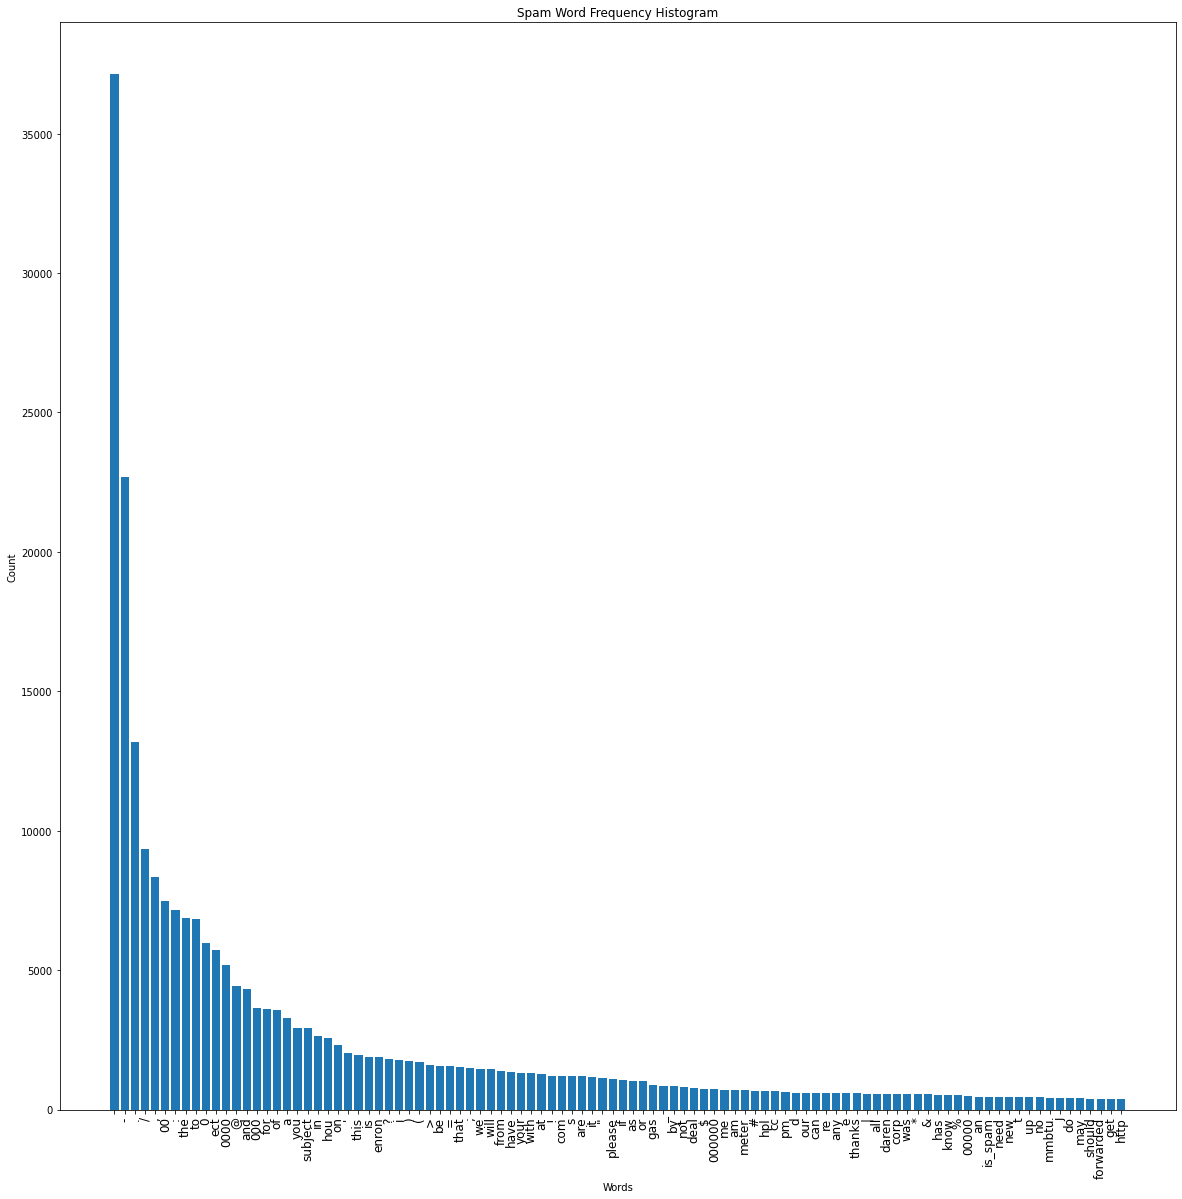

<Figure size 14400x7200 with 0 Axes>

In [ ]:


label_rows = sorted_df.loc[labeled_sorted_df['label_num'] == 1]

col_sums = label_rows.sum(axis=0)

plt.bar(sorted_df.columns[:100], col_sums.nlargest(n=100), width=0.8)

# Set the plot title and axis labels
plt.title('Spam Word Frequency Histogram')
plt.xlabel('Words')
plt.xticks(fontsize=12, rotation=90)

plt.ylabel('Count')
plt.figure(figsize=(100,50), dpi=144)
plt.show()

  We decided to keep special charecters (such as '\\n' , '-', '.', etc) within the dataset as they might have a meaning, which we don't want to loose.


Another method we tried to apply in order to identify outliers is IQR test. 

Unfortuntly there were identified too many outliers, so we dropped this.


In [ ]:
label = "is_spam"
get_x = lambda d: d.drop(label, axis=1)
get_y = lambda d: d[label]
get_d = lambda x, y: pd.concat([x, y], axis=1)

x, y = get_x(sorted_df), get_y(sorted_df)

In [ ]:
# IRQ test for outliers

upper_bound = x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25))
lower_bound = x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25))
outliers_indexes = ((x > upper_bound) | (x < lower_bound))
outliers_parcentage = outliers_indexes.sum(axis=0)/x.shape[0]
min, max = outliers_parcentage.argmin(), outliers_parcentage.argmax()
print(f"outliers parcentage - min: {100*outliers_parcentage[min]:0.3f}%, max: {100*outliers_parcentage[max]:0.3f}%")
emails_with_any_outliers = np.any(outliers_indexes, axis=1)
print("emails with outlayers: ", emails_with_any_outliers.sum(), "/", len(x))

outliers parcentage - min: 0.019%, max: 24.927%
emails with outlayers:  5154 / 5171


As you can see almost all the emails contain at least one outlier, therefore we can't delete them. Even increasing the IQR coefficient to 10 instead of 1.5, doesn't help us reach a reasonable number of outliers.  


# ***Limitation***
One of the main challenges was the large dimension of the input vector comparing to the number of sampales. 
Therefore, as we mentioned above, we removed all the words that appear less than 10 time. We are still left with abit more features than samples, but it is tolerable.



normlize, shuffle and separate our data into training, validation, and test.
70%, 15%, 15%

In [ ]:
x = (x-x.mean(axis=0))/x.std(axis=0)
num_of_features = x.shape[1]
data = get_d(x,y)
data = data.sample(frac = 1).reset_index(drop=True)
train, valid, test = data[:round(len(data)*0.7)].reset_index(drop=True), data[round(len(data)*0.7):round(len(data)*0.85)].reset_index(drop=True), data[round(len(data)*0.85):].reset_index(drop=True)


# ***Network***
Our problem is a binary classification problem - spam or not. Therefore we used BCE(BinaryCrossEntropy) as our loss function.

We used a fully connected layer for this task. The last layer is Sigmoid, which is known to be effective with BCE loss function, and the rest are Relu with fully connected linear layers in between.

We decided to build a dynamic model, which allowed us to test and compare different structures.

We used Adam optimization as our optimizer.


In [ ]:
class DynamicModel(nn.Module):
    def __init__(self, layers, learning_rate=0.0005, optimizer=optim.Adam):
        """
        # example
        fully_connected_layers = [
          {
              "output_size": 100,
              "activation": nn.ReLU()
          },
          {
              "output_size": 6,
              "activation": nn.Sigmoid()
          }
          # add more
        ]
        """
        super().__init__()
        self.input_layers = layers  # only used to extract it later
        self.layers = nn.ModuleList()
        previous_layer_size = num_of_features
        for layer in layers:
            self.layers.append(nn.Linear(previous_layer_size, layer["output_size"]))
            self.layers.append(layer["activation"])
            previous_layer_size = layer["output_size"]
        
        self.layers.append(nn.Linear(previous_layer_size, 1))
        self.layers.append(nn.Sigmoid())

        self.learning_rate = learning_rate
        self.optimizer = optimizer(params=self.parameters(), lr=learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[:, 0]

    def decide(self, x):
        return x > 0.5
        
    def __str__(self):
        res = "input"
        for layer in self.layers[1::2]:
            res += f" -> {layer}"
        return res


We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.


In [ ]:
def estimate_accuracy(model, data):
    pred = model(torch.Tensor(get_x(data).values))
    pred = (model.decide(pred)).detach().numpy() # convert the PyTorch tensor => numpy array
    correct = np.mean(pred == get_y(data))
    return correct


In [ ]:
# this code will allow us to save and compare the best models over all trainings
from collections import namedtuple

ModelParams = namedtuple("model", ["state_dict", "layers", "model_str","learning_rate", "epoch", "batch_num", "batch_size", "val_acc"])
best_model = ModelParams(None, None, "", 0, 0, 0, 0, 0)

best_model_path = '/content/drive/MyDrive/Intro_to_Deep_Learning/project_best_model.pt' 

In [ ]:

def train_model(model, train_data, valid_data, num_epochs=0, batch_size=0, to_print=False):
    global best_model
    # training data
    criterion = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters())
    sample_reduction = 1
    epochs, losses, val_accs, train_accs = [], [], [], []
    get_batch = lambda d, b: [torch.Tensor(get_x(d[b:b+batch_size]).values), 
                              torch.Tensor(get_y(d[b:b+batch_size]).values)]
    best_epoch_model = ModelParams(None, None, "", 0, 0, 0, 0, 0)
    
    for epoch in range(num_epochs):
        for b in range(0, train_data.shape[0]-batch_size+1, batch_size):
          # get the input and targets of a minibatch
          [xt, st] = get_batch(train_data, b)
          pred = model(xt)
          loss = criterion(pred, st)

          # Zero gradients, perform a backward pass, and update the weights.
          loss.backward()
          optimizer.step()
          optimizer.zero_grad() 

          losses.append(float(loss)/batch_size)
          train_accs.append(estimate_accuracy(model, train_data))
          val_accs.append(estimate_accuracy(model, valid_data))
          epochs.append(epoch + b/train_data.shape[0])

          if to_print:
              print("epoch %d,\tbatch %d\t[Val Acc %.3f%%] [Train Acc %.3f%%, Loss %f]" % (
                    epoch, b//batch_size, val_accs[-1] * 100, train_accs[-1] * 100, losses[-1]))
          
          # update this session best model if needed
          if best_epoch_model.val_acc < val_accs[-1]:
            best_epoch_model = ModelParams(model.state_dict(), model.input_layers, str(model), model.learning_rate, epoch, b//batch_size, batch_size, val_accs[-1])

    # update and save overall best model if needed
    if best_epoch_model.val_acc > best_model.val_acc:
      best_model = best_epoch_model
      torch.save(best_model.state_dict, best_model_path)

    plt.figure(figsize=(12,8))
    plt.suptitle(f"{best_epoch_model.model_str}\n"
                 f"batch size: {best_epoch_model.batch_size}, learning rate: {best_epoch_model.learning_rate}\n"
                 f"epoches: {best_epoch_model.epoch}/{num_epochs}, batch: {best_epoch_model.batch_num}/{train_data.shape[0]//batch_size}"
                 f" - acc: {best_epoch_model.val_acc*100:.3f}%", fontsize=22)
    plt.subplot(2,1,1)
    plt.title("Learning Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(2,1,2)
    plt.title("Learning Curve")
    plt.plot(epochs, train_accs, label="Train")
    plt.plot(epochs, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.subplots_adjust(hspace=0.4, wspace=0.2, left=0.1, bottom=0.1, right=0.9, top=0.8)
    plt.show()


 Then testing several different layer structures

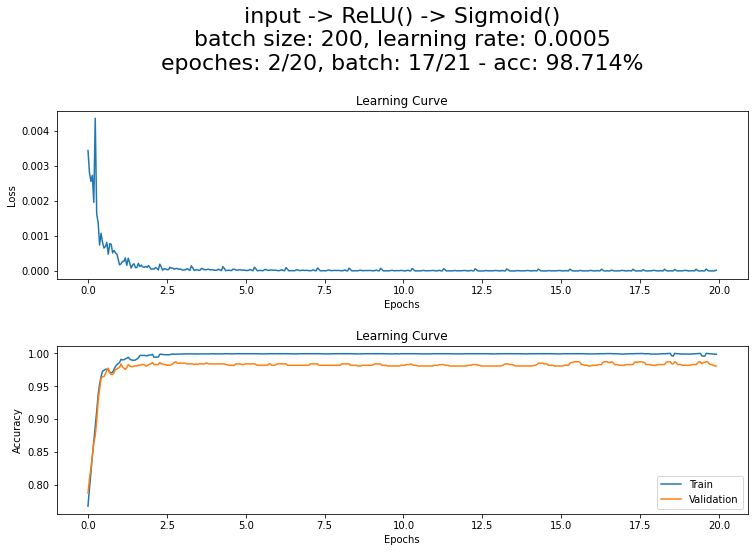

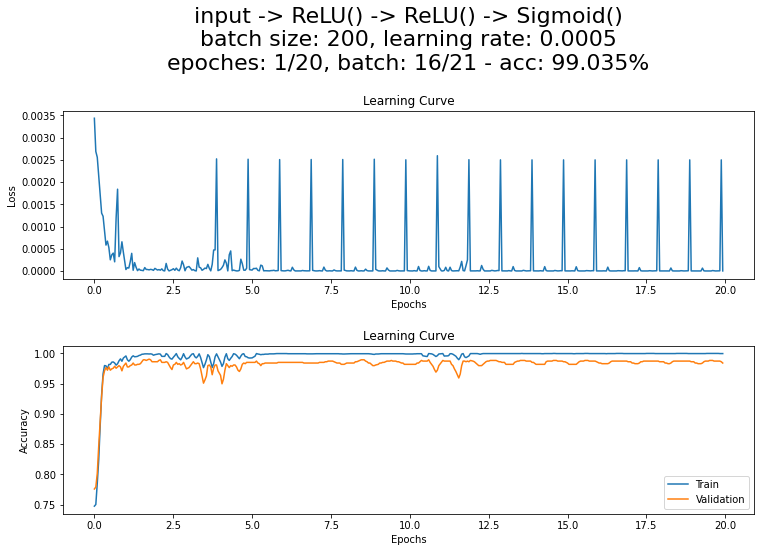

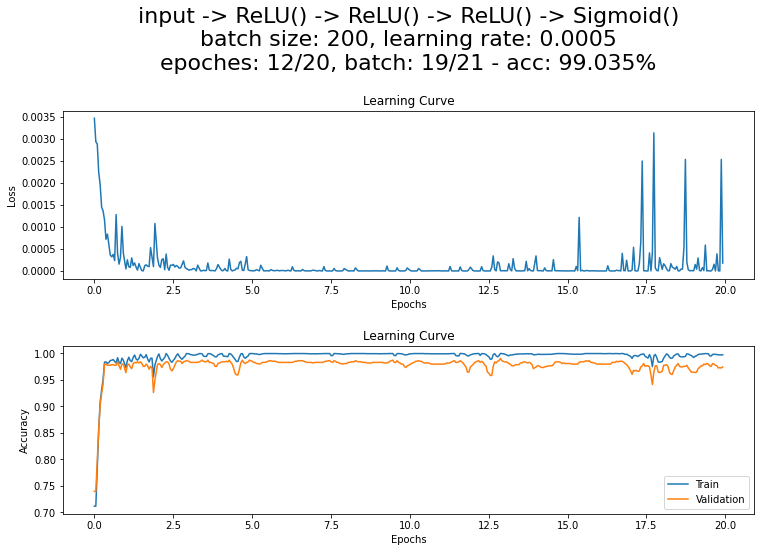

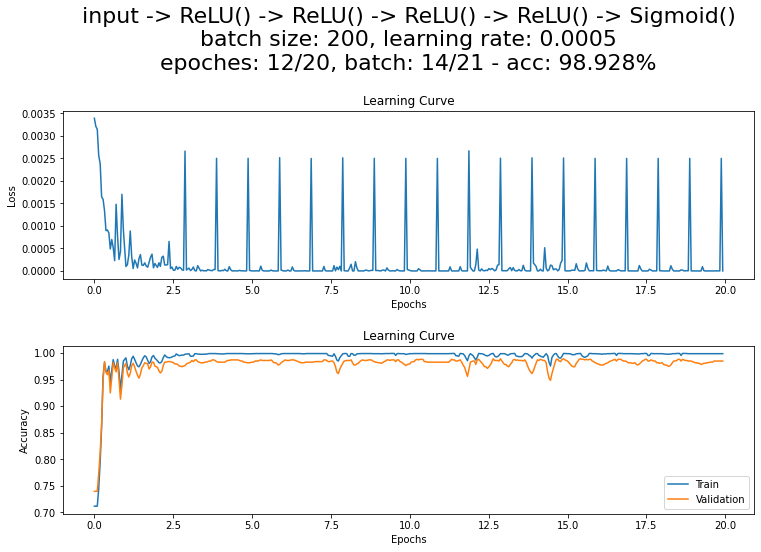

In [ ]:
layers1 = [
    {
        "output_size": 300,
        "activation": nn.ReLU()
    }
]

layers2 = [
    {
        "output_size": 1000,
        "activation": nn.ReLU()
    },
    {
        "output_size": 100,
        "activation": nn.ReLU()
    }
]

layers3 = [
    {
        "output_size": 2000,
        "activation": nn.ReLU()
    },
    {
        "output_size": 800,
        "activation": nn.ReLU()
    },
    {
        "output_size": 70,
        "activation": nn.ReLU()
    }
]

layers4 = [
    {
        "output_size": 2500,
        "activation": nn.ReLU()
    },
    {
        "output_size": 1000,
        "activation": nn.ReLU()
    },
    {
        "output_size": 200,
        "activation": nn.ReLU()
    },
    {
        "output_size": 50,
        "activation": nn.ReLU()
    }
]

all_layers = [layers1, layers2, layers3, layers4]

for l in all_layers:
    model = DynamicModel(l)
    train_model(model, train, valid, num_epochs=20, batch_size=200)

#### Comparing the two best layer structures against other learning rates

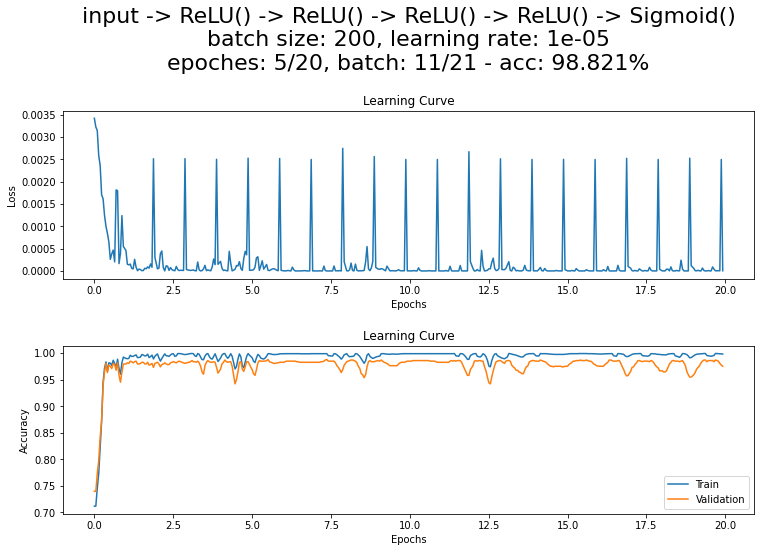

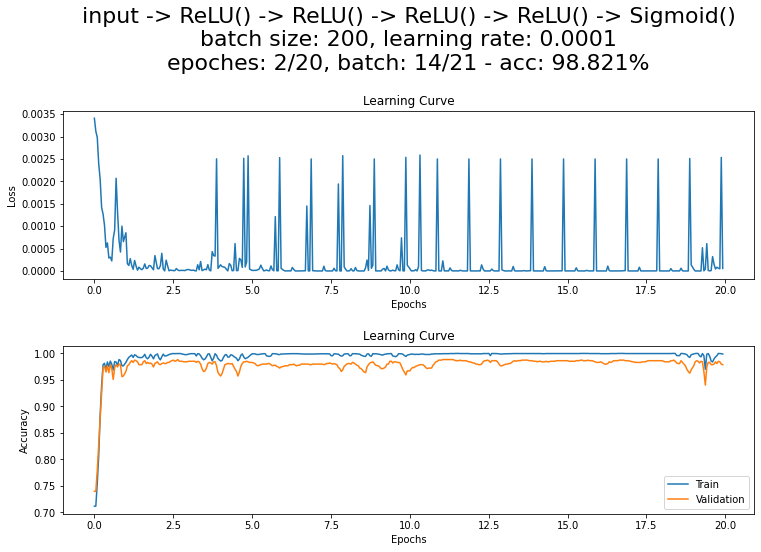

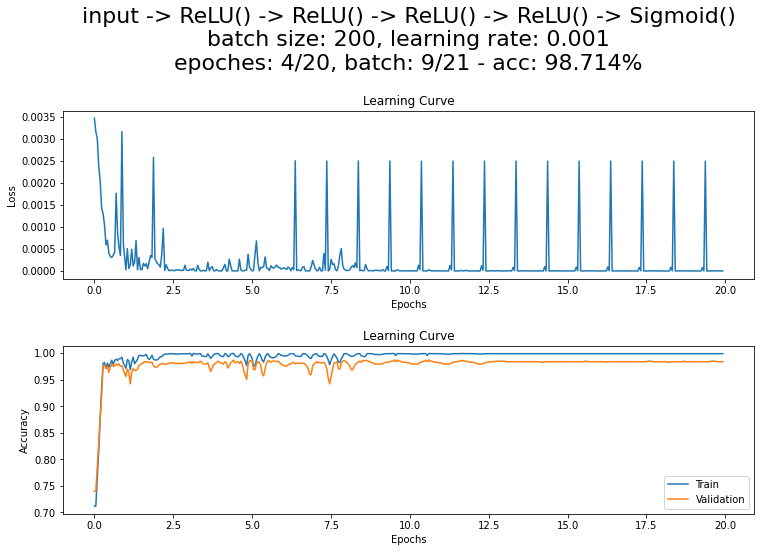

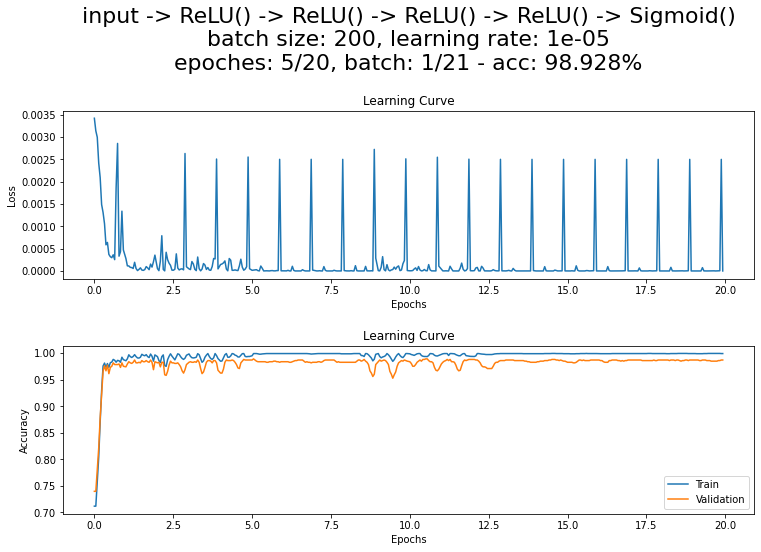

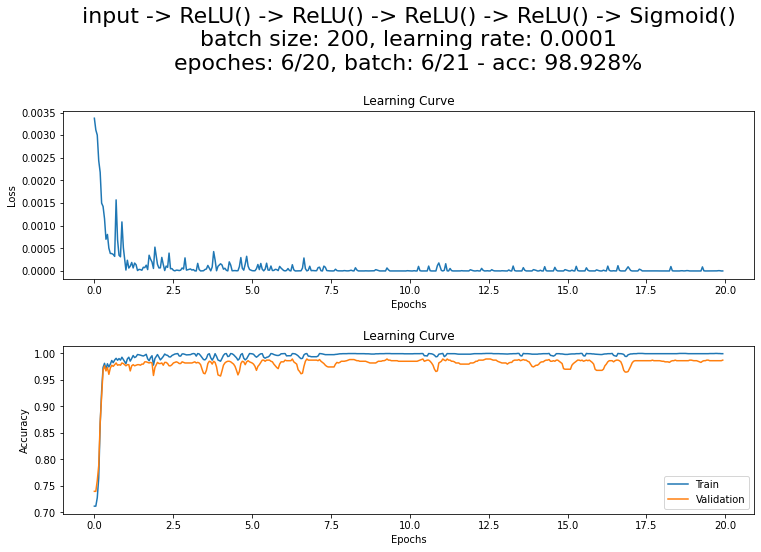

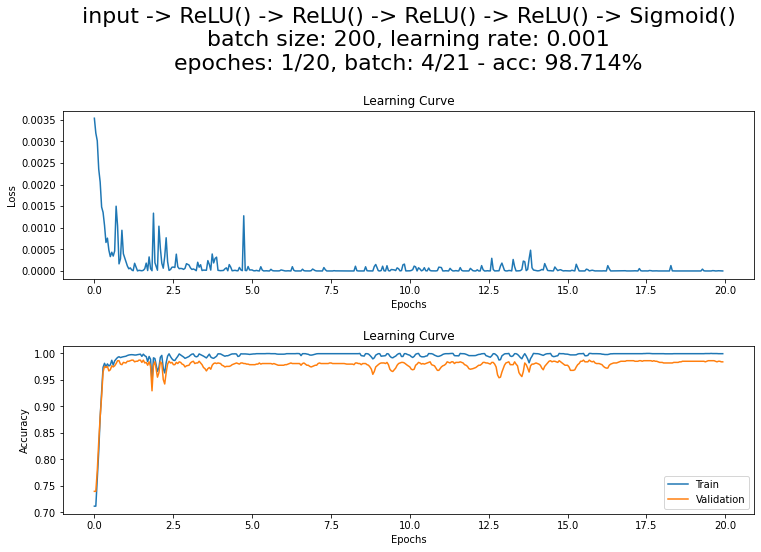

In [ ]:
all_layers = [layers3, layers4]

for layer in all_layers:
    for learn in [0.00001, 0.0001, 0.001]:
        model = DynamicModel(l, learning_rate=learn)
        train_model(model, train, valid, num_epochs=20, batch_size=200)

As we can wee, the best model scores almost 99% accuracy.

# ***Results***


In [ ]:
model = DynamicModel(best_model.layers, learning_rate=best_model.learning_rate)
model.load_state_dict(torch.load(best_model_path))

test_accuracy = estimate_accuracy(model, test)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.9774678111587983


#***Benchmark***

We learned from the submitters at Kaggle, that the best results achieved 99% accuracy in classification.

A similar number has appeared in other websites that claimed to build such classifier..

These submitters, were trying different training methods (such as Logistic Regression, KNN, SVM, Naive Bayes, Decision Tree, Random Forest etc), in order to build their classifier model, and reached out about 97 accuracy percentage ([link](https://www.kaggle.com/code/anurag629/uncovering-the-best-email-spam-classifier) ).

Others reached almost 98 accuracy percentage with a MultiLayer perceptron classifier like we did. 
([link](https://www.kaggle.com/code/shivanielakurthy/email-spam-classification-using-mlp-classification)).

Our model reaches a high accuracy percentage of almost 98%, which puts us at a good place at the top of the list. 

# ***Conclusions***

In this project, we built an email spam detector using a Multi-Layer Perceptron classifier which we optimized it's layers structure dynamically, seeking for the one structure which will maximize our accuracy rate.

Prior to that, we obtained our data set of labled emails from Kaggle's website, which we then had to preprocess.
Preprocessing included splitting the emails into words, sorting them by the most common ones, then trying to remove outliers.

As mentioned before, we trained the model over differenet layer-structure and different hyper-parameters, lasting with the best one.

Finally, compared to the best provided solutions on Kaggle, we are placed in a good spot at the top, which indicates our model's quality. 